In [1]:
import os
import pandas as pd
from torchvision.io import read_image
from torch.utils.data import Dataset
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
import torchvision
import cv2
import torch
import torch.nn
import pandas as pd 
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import torch.nn as nn
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from tqdm import tqdm, trange
import math

In [2]:
label_df = pd.read_csv('./FracAtlas/dataset.csv')
fractured_df = label_df[label_df['fractured'] == 1]
unfractured_df = label_df[label_df['fractured'] == 0]

train_frac_df, val_frac_df = train_test_split(fractured_df, test_size=0.2)
train_unfrac_df, val_unfrac_df = train_test_split(unfractured_df, test_size=0.2)

train_df = pd.concat((train_frac_df, train_unfrac_df))
val_df = pd.concat((val_frac_df, val_unfrac_df))

val_df.reset_index(inplace = True)
train_df.reset_index(inplace = True)

In [3]:
class CustomImageDataset(Dataset):
    def __init__(self, annotation_df, img_dir, transform=None, target_transform=None):
        self.img_labels = annotation_df
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.loc[idx, 'image_id'])
#         print(img_path)
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        image = torch.tensor(image, dtype= torch.float32).unsqueeze(0)
#         image = torch.tensor(image).unsqueeze(0)
        label = self.img_labels.loc[idx, 'fractured']
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [4]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(256),
    transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
#     transforms.RandomRotation(30),  # Randomly rotate the image
    transforms.ColorJitter(brightness=0.5, contrast=0.5),  # Adjust brightness and contrast
    transforms.Normalize(mean=[0.406], std=[0.225])
    
])


train_dataset = CustomImageDataset(train_df, './FracAtlas/images/Compiled/', transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=24, shuffle=True)

val_dataset = CustomImageDataset(val_df, './FracAtlas/images/Compiled/', transform=transform)
val_dataloader = DataLoader(val_dataset, batch_size=24, shuffle=True)

Feature batch shape: torch.Size([24, 1, 256, 256])


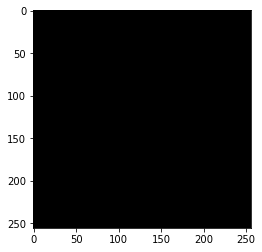

Label: 0


In [5]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

In [6]:
class PatchEncoder(nn.Module):
    def __init__(self, config):
        super(PatchEncoder, self).__init__()
        self.encoding_size = config['encoding_size']
        self.img_dim = config['img_dim']
        self.dropout = config['dropout']
        self.patch_size = config['patch_size']
        assert self.img_dim % self.patch_size == 0, ("Image is not compatible with number of patches")
        self.cls_token = nn.Parameter(torch.randn(1, 1, self.encoding_size))
        self.n_patches = (self.img_dim//self.patch_size)**2
        self.encoder = nn.Conv2d(1, self.encoding_size, kernel_size=self.patch_size, stride=self.patch_size)
        self.pos_encoder = nn.Parameter(torch.randn(1, self.n_patches + 1, self.encoding_size))
        self.dropout_layer = nn.Dropout(self.dropout)
        
    def forward(self, x):
        out = self.encoder(x)
        cls_token = self.cls_token.expand((x.shape[0], -1, -1))
        out = out.flatten(-2).transpose(-1, -2)
        out = torch.cat((cls_token, out), dim = 1)
        print(out.shape, self.pos_encoder.shape)
        out = out + self.pos_encoder
        return self.dropout_layer(out)
        

In [7]:
class MultiHeadAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        

        self.d_model = config['encoding_size']           # Total dimension of the model
        self.num_heads = config['num_heads']       # Number of attention heads
        assert self.d_model % self.num_heads == 0, 'd_model must be divisible by num_heads'
        self.d_k = self.d_model // self.num_heads  # Dimnsion of each head. We assume d_v = d_k

        # Linear transformations for queries, keys, and values
        self.W_q = nn.Linear(self.d_model, self.d_model)
        self.W_k = nn.Linear(self.d_model, self.d_model)
        self.W_v = nn.Linear(self.d_model, self.d_model)

        # Final linear layer to project the concatenated heads' outputs back to d_model dimensions
        self.W_o = nn.Linear(self.d_model, self.d_model)

    def scaled_dot_product_attention(self, Q, K, V):
        scores = torch.matmul(Q, K.transpose(-2, -1))
        attn_weights = torch.softmax(scores / math.sqrt(self.d_k), dim = -1)
        output = torch.matmul(attn_weights, V)
        return output

    def split_heads(self, x):
        batch_size, seq_length, d_model = x.size()
        return x.view(batch_size, seq_length, self.num_heads, self.d_k).transpose(1, 2)

    def combine_heads(self, x):
        batch_size, num_heads, seq_length, d_k = x.size()
        return x.transpose(1, 2).contiguous().view(batch_size, seq_length, self.d_model)

    def forward(self, x):
        Q_proj = self.W_q(x)
        K_proj = self.W_k(x)
        V_proj = self.W_v(x)

        Q_proj_split = self.split_heads(Q_proj)
        K_proj_split = self.split_heads(K_proj)
        V_proj_split = self.split_heads(V_proj)

        attention_scores = self.scaled_dot_product_attention(Q_proj_split, K_proj_split, V_proj_split)

        output = self.combine_heads(attention_scores)
        output = self.W_o(output)

        return output

In [8]:
class MLP(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.encoding_size = config['encoding_size']
        self.intermediate_size = config['intermediate_size']
        self.dense_1 = nn.Linear(self.encoding_size, self.intermediate_size)
        self.activation = nn.GELU()
        self.dense_2 = nn.Linear(self.intermediate_size, self.encoding_size)
        self.dropout = nn.Dropout(config['dropout'])

    def forward(self, x):
        x = self.dense_1(x)
        x = self.activation(x)
        x = self.dense_2(x)
        x = self.dropout(x)
        return x

In [9]:
class Block(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.encoding_size = config['encoding_size']
        self.attention = MultiHeadAttention(config)
        self.layernorm_1 = nn.LayerNorm(self.encoding_size)
        self.mlp = MLP(config)
        self.layernorm_2 = nn.LayerNorm(self.encoding_size)

    def forward(self, x):
        attention_output = self.attention(self.layernorm_1(x))
        x = x + attention_output
        mlp_output = self.mlp(self.layernorm_2(x))
        x = x + mlp_output
        return x

In [10]:
class Encoder(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.blocks = nn.ModuleList([])
        for _ in range(config["num_hidden_layers"]):
            block = Block(config)
            self.blocks.append(block)

    def forward(self, x):
        all_attentions = []
        for block in self.blocks:
            x = block(x)
        return x

In [11]:
class ViTForClassfication(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.encoding_size = config["encoding_size"]
        self.num_classes = config["num_classes"]
        self.embedding = PatchEncoder(config)
        self.encoder = Encoder(config)
        self.classifier = nn.Linear(self.encoding_size, self.num_classes)

    def forward(self, x, output_attentions=False):
        embedding_output = self.embedding(x)
        encoder_output = self.encoder(embedding_output)
        logits = self.classifier(encoder_output[:, 0])
        return logits

In [15]:
# img = torch.rand((23, 1, 35, 35))
# config = {
#     'encoding_size': 1024,
#     'patch_size': 10,
#     'img_dim': 400,
#     'dropout': 0.1,
#     'num_heads': 6,
#     'num_hidden_layers': 3,
#     'intermediate_size': 2048,
#     'num_classes': 2
# }

config = {
    "encoding_size": 128,  # Change this according to your ViT model
    "num_classes": 2,     # MNIST has 10 output classes (digits 0-9)
    "num_heads": 8,
    "img_dim": 256,         # Resize the MNIST images to 32x32
    "patch_size": 8,       # Assuming 32x32 images, patch size = 4 means 8x8 patches
    "dropout": 0.1,
    'num_hidden_layers': 3,
    'intermediate_size': 4*128,
}
# Model (replace `ViTForClassification` with your actual ViT class name)
vit = ViTForClassfication(config)
vit = vit.cuda()  

optimizer = Adam(vit.parameters(), lr=0.0005)
criterion = CrossEntropyLoss()

# Training loop
for epoch in trange(5, desc="Training"):
    train_loss = 0.0
    iteration = 0  # To track the number of iterations

    for batch in tqdm(train_dataloader, desc=f"Epoch {epoch + 1} in training", leave=False):
        iteration += 1
        
        # Training Step
        x, y = batch
        x, y = x.cuda(), y.cuda()  # Assuming you're using a GPU
        y_hat = vit(x)
        loss = criterion(y_hat, y)

        train_loss += loss.detach().cpu().item() / len(train_dataloader)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Validation step after every 10 iterations
        if iteration % 10 == 0:
            val_loss = 0.0
            correct = 0
            total = 0

            model.eval()  # Set the model to evaluation mode
            with torch.no_grad():  # Disable gradient computation
                for val_batch in val_dataloader:
                    val_x, val_y = val_batch
                    val_x, val_y = val_x.cuda(), val_y.cuda()

                    val_y_hat = vit(val_x)
                    val_loss += criterion(val_y_hat, val_y).item() / len(val_dataloader)

                    # Calculate accuracy
                    _, predicted = torch.max(val_y_hat, 1)
                    correct += (predicted == val_y).sum().item()
                    total += val_y.size(0)

            val_accuracy = correct / total

            print(f"Iteration {iteration}: Validation Loss: {val_loss:.2f}, Validation Accuracy: {val_accuracy:.2f}")
            model.train()  # Switch back to training mode

    print(f"Epoch {epoch + 1}/{N_EPOCHS} loss: {train_loss:.2f}")

Epoch 1 in training:   0%|                                                                     | 0/137 [00:00<?, ?it/s]

torch.Size([24, 1025, 128]) torch.Size([1, 1025, 128])



Epoch 1 in training:   1%|▍                                                            | 1/137 [00:03<07:09,  3.16s/it]

torch.Size([24, 1025, 128]) torch.Size([1, 1025, 128])



Epoch 1 in training:   1%|▉                                                            | 2/137 [00:04<04:14,  1.89s/it]

torch.Size([24, 1025, 128]) torch.Size([1, 1025, 128])



Epoch 1 in training:   2%|█▎                                                           | 3/137 [00:06<04:40,  2.09s/it]

torch.Size([24, 1025, 128]) torch.Size([1, 1025, 128])



Epoch 1 in training:   3%|█▊                                                           | 4/137 [00:08<04:50,  2.19s/it]

torch.Size([24, 1025, 128]) torch.Size([1, 1025, 128])



Epoch 1 in training:   4%|██▏                                                          | 5/137 [00:11<04:55,  2.24s/it]

torch.Size([24, 1025, 128]) torch.Size([1, 1025, 128])



Epoch 1 in training:   4%|██▋                                                          | 6/137 [00:13<04:57,  2.27s/it]

torch.Size([24, 1025, 128]) torch.Size([1, 1025, 128])



Epoch 1 in training:   5%|███                                                          | 7/137 [00:15<04:57,  2.29s/it]

torch.Size([24, 1025, 128]) torch.Size([1, 1025, 128])



Epoch 1 in training:   6%|███▌                                                         | 8/137 [00:18<04:57,  2.30s/it]

torch.Size([24, 1025, 128]) torch.Size([1, 1025, 128])



Epoch 1 in training:   7%|████                                                         | 9/137 [00:20<04:56,  2.31s/it]

torch.Size([24, 1025, 128]) torch.Size([1, 1025, 128])
torch.Size([24, 1025, 128]) torch.Size([1, 1025, 128])
torch.Size([24, 1025, 128]) torch.Size([1, 1025, 128])
torch.Size([24, 1025, 128]) torch.Size([1, 1025, 128])
torch.Size([24, 1025, 128]) torch.Size([1, 1025, 128])
torch.Size([24, 1025, 128]) torch.Size([1, 1025, 128])
torch.Size([24, 1025, 128]) torch.Size([1, 1025, 128])
torch.Size([24, 1025, 128]) torch.Size([1, 1025, 128])
torch.Size([24, 1025, 128]) torch.Size([1, 1025, 128])
torch.Size([24, 1025, 128]) torch.Size([1, 1025, 128])
torch.Size([24, 1025, 128]) torch.Size([1, 1025, 128])
torch.Size([24, 1025, 128]) torch.Size([1, 1025, 128])
torch.Size([24, 1025, 128]) torch.Size([1, 1025, 128])
torch.Size([24, 1025, 128]) torch.Size([1, 1025, 128])
torch.Size([24, 1025, 128]) torch.Size([1, 1025, 128])
torch.Size([24, 1025, 128]) torch.Size([1, 1025, 128])
torch.Size([24, 1025, 128]) torch.Size([1, 1025, 128])
torch.Size([24, 1025, 128]) torch.Size([1, 1025, 128])
torch.Size


Epoch 1 in training:   7%|████▍                                                       | 10/137 [00:36<13:37,  6.44s/it]

Iteration 10: Validation Loss: 0.57, Validation Accuracy: 0.80
torch.Size([24, 1025, 128]) torch.Size([1, 1025, 128])



Epoch 1 in training:   8%|████▊                                                       | 11/137 [00:37<10:05,  4.80s/it]

torch.Size([24, 1025, 128]) torch.Size([1, 1025, 128])



Epoch 1 in training:   9%|█████▎                                                      | 12/137 [00:39<08:26,  4.05s/it]

torch.Size([24, 1025, 128]) torch.Size([1, 1025, 128])



Epoch 1 in training:   9%|█████▋                                                      | 13/137 [00:41<07:18,  3.53s/it]

torch.Size([24, 1025, 128]) torch.Size([1, 1025, 128])



Epoch 1 in training:  10%|██████▏                                                     | 14/137 [00:44<06:29,  3.17s/it]

torch.Size([24, 1025, 128]) torch.Size([1, 1025, 128])



Epoch 1 in training:  11%|██████▌                                                     | 15/137 [00:46<05:56,  2.92s/it]

torch.Size([24, 1025, 128]) torch.Size([1, 1025, 128])



Epoch 1 in training:  12%|███████                                                     | 16/137 [00:48<05:31,  2.74s/it]

torch.Size([24, 1025, 128]) torch.Size([1, 1025, 128])



Epoch 1 in training:  12%|███████▍                                                    | 17/137 [00:51<05:14,  2.62s/it]

torch.Size([24, 1025, 128]) torch.Size([1, 1025, 128])



Epoch 1 in training:  13%|███████▉                                                    | 18/137 [00:53<05:01,  2.53s/it]

torch.Size([24, 1025, 128]) torch.Size([1, 1025, 128])



Epoch 1 in training:  14%|████████▎                                                   | 19/137 [00:55<04:51,  2.47s/it]

torch.Size([24, 1025, 128]) torch.Size([1, 1025, 128])
torch.Size([24, 1025, 128]) torch.Size([1, 1025, 128])
torch.Size([24, 1025, 128]) torch.Size([1, 1025, 128])
torch.Size([24, 1025, 128]) torch.Size([1, 1025, 128])
torch.Size([24, 1025, 128]) torch.Size([1, 1025, 128])
torch.Size([24, 1025, 128]) torch.Size([1, 1025, 128])
torch.Size([24, 1025, 128]) torch.Size([1, 1025, 128])
torch.Size([24, 1025, 128]) torch.Size([1, 1025, 128])
torch.Size([24, 1025, 128]) torch.Size([1, 1025, 128])
torch.Size([24, 1025, 128]) torch.Size([1, 1025, 128])
torch.Size([24, 1025, 128]) torch.Size([1, 1025, 128])
torch.Size([24, 1025, 128]) torch.Size([1, 1025, 128])
torch.Size([24, 1025, 128]) torch.Size([1, 1025, 128])
torch.Size([24, 1025, 128]) torch.Size([1, 1025, 128])
torch.Size([24, 1025, 128]) torch.Size([1, 1025, 128])
torch.Size([24, 1025, 128]) torch.Size([1, 1025, 128])
torch.Size([24, 1025, 128]) torch.Size([1, 1025, 128])
torch.Size([24, 1025, 128]) torch.Size([1, 1025, 128])
torch.Size


Epoch 1 in training:  15%|████████▊                                                   | 20/137 [01:11<12:12,  6.26s/it]

torch.Size([2, 1025, 128]) torch.Size([1, 1025, 128])
Iteration 20: Validation Loss: 0.46, Validation Accuracy: 0.82
torch.Size([24, 1025, 128]) torch.Size([1, 1025, 128])



Epoch 1 in training:  15%|█████████▏                                                  | 21/137 [01:11<09:00,  4.66s/it]

torch.Size([24, 1025, 128]) torch.Size([1, 1025, 128])



Epoch 1 in training:  16%|█████████▋                                                  | 22/137 [01:14<07:35,  3.96s/it]

torch.Size([24, 1025, 128]) torch.Size([1, 1025, 128])



Training:   0%|                                                                                  | 0/5 [01:18<?, ?it/s]


KeyboardInterrupt: 

In [375]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.optim import Adam
# from torch.nn import CrossEntropyLoss
# from torchvision import datasets, transforms
# from torch.utils.data import DataLoader
# from tqdm import trange, tqdm

# # Configuration for the ViT model (you can adjust these as per your model design)
# config = {
#     "encoding_size": 128,  # Change this according to your ViT model
#     "num_classes": 10,     # MNIST has 10 output classes (digits 0-9)
#     "num_heads": 8,
#     "img_dim": 32,         # Resize the MNIST images to 32x32
#     "patch_size": 4,       # Assuming 32x32 images, patch size = 4 means 8x8 patches
#     "dropout": 0.1,
#     'num_hidden_layers': 3,
#     'intermediate_size': 4*128,
# }

# # Model (replace `ViTForClassification` with your actual ViT class name)
# model = ViTForClassfication(config)
# model = model.cuda()  # Move the model to the GPU

# # Preprocessing and loading the MNIST dataset
# transform = transforms.Compose([
#     transforms.Resize((32, 32)),  # Resize the 28x28 images to 32x32
#     transforms.ToTensor(),
#     transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1] range
# ])

# # Load the MNIST dataset
# train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
# val_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

# # Create DataLoader for training and validation
# train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
# val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# # Optimizer and loss function
# optimizer = Adam(model.parameters(), lr=0.001)
# criterion = CrossEntropyLoss()

# # Training loop
# N_EPOCHS = 5
# for epoch in trange(N_EPOCHS, desc="Training"):
#     train_loss = 0.0
#     iteration = 0  # To track the number of iterations

#     for batch in tqdm(train_dataloader, desc=f"Epoch {epoch + 1} in training", leave=False):
#         iteration += 1

#         # Training Step
#         x, y = batch
#         x, y = x.cuda(), y.cuda()  # Assuming you're using a GPU
#         y_hat = model(x)
#         loss = criterion(y_hat, y)

#         train_loss += loss.detach().cpu().item() / len(train_dataloader)

#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#         # Validation step after every 10 iterations
#         if iteration % 10 == 0:
#             val_loss = 0.0
#             correct = 0
#             total = 0

#             model.eval()  # Set the model to evaluation mode
#             with torch.no_grad():  # Disable gradient computation
#                 for val_batch in val_dataloader:
#                     val_x, val_y = val_batch
#                     val_x, val_y = val_x.cuda(), val_y.cuda()

#                     val_y_hat = model(val_x)
#                     val_loss += criterion(val_y_hat, val_y).item() / len(val_dataloader)

#                     # Calculate accuracy
#                     _, predicted = torch.max(val_y_hat, 1)
#                     correct += (predicted == val_y).sum().item()
#                     total += val_y.size(0)

#             val_accuracy = correct / total

#             print(f"Iteration {iteration}: Validation Loss: {val_loss:.2f}, Validation Accuracy: {val_accuracy:.2f}")
#             model.train()  # Switch back to training mode

#     print(f"Epoch {epoch + 1}/{N_EPOCHS} loss: {train_loss:.2f}")
